In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.special import softmax
from scipy.optimize import minimize

from datetime import datetime

import matplotlib.pyplot as plt

## Andmed

In [2]:
df = pd.read_csv('andmed/spioonid.csv')

df['kuupäev'] = df['kuupäev'].apply(lambda x: datetime.fromisoformat(x))
df['m'] = df['kuupäev'].apply(lambda x: x.timetuple().tm_yday)
df['m'] = df.groupby('m').ngroup()
df['t'] = df['kuupäev'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0)).total_seconds() / 3600)

df = df.drop(columns=['kuupäev'])
df.head()

,m,t
0,0,14.183333
1,0,17.500000
2,0,18.533333
3,0,21.566667
4,0,22.083333


## Protsessi intensiivsus

\begin{equation}
    \lambda_z(t) = \sum_{k = 1}^K a_{z k} B_k(t) ,
\end{equation}
kus
\begin{align}
    B_k(t) &= \frac{1}{\sigma \sqrt{2 \pi}} \exp \left\{ - \frac{(t - \mu_k)^2}{2 \sigma^2} \right\} , \\
    \mu_k &= \frac{(k - 1) \tau}{K - 1} , \qquad \sigma_k = \frac{\tau}{k} .
\end{align}

In [3]:
K = 20  # number of gaussian variables
m = df['m'].nunique()  # number of event series
Z = 1  # number of parent processes

k = np.arange(1, K + 1)
tau = df['t'].max()
locs = ((k - 1) * tau) / (K - 1)
scales = tau / k

In [4]:
def rate(x, process_weights, locs=locs, scales=scales):
    return np.sum(process_weights * norm.pdf(x, loc=locs, scale=scales))


def joint_pdf(X, process_weights):
    integral = np.sum(process_weights * norm.cdf(tau, loc=locs, scale=scales))
    return np.exp(-integral) * np.prod([rate(x, process_weights) for x in X])  # !! aeglane !!

### EM
\begin{equation*}
    \theta = \langle \boldsymbol{\lambda} , \textbf{p} \rangle ,
\end{equation*}
millest
\begin{equation*}
    \boldsymbol{\lambda} = \langle \lambda_1 , \lambda_2 , \dots , \lambda_Z \rangle , \quad \textbf{p} = \langle p_1 , p_2 , \dots , p_Z \rangle .
\end{equation*}

In [5]:
weights = np.ones((Z, K), dtype=np.longdouble)
originating_probabilities = softmax(np.zeros((m, Z), dtype=np.longdouble))
mixing_probabilities = np.mean(originating_probabilities, axis=0)

#### Ooteväärtuse samm
Antud parameetrivektori $\theta^r$ korral
\begin{equation}
    p_{iz}^r = \frac{ e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) }{ \sum_{q = 1}^{Z} e^{- \Lambda_q (0 , \tau)} \prod_{j = 1}^n \lambda_q (t_{ij}) }
\end{equation}
tõenäosused, et sündmuste seeria $\textbf{t}_i$ tuli ülemprotsessilt $z$

In [6]:
def expectation_step(data, orig_probs_shape, weights):
    gp = data.groupby('m')['t']
    orig_probs = np.zeros(orig_probs_shape)
    
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.get_group(i)
        
        numerator = joint_pdf(t_vec, weights[z])
        denominator = np.sum([joint_pdf(t_vec, weights[q]) for q in range(Z)])
        
        orig_probs[(i, z)] = numerator / denominator
    
    return orig_probs

#### Maksimeerimise samm
\begin{equation}
    \theta^{r + 1} = \underset{\theta}{\arg \max} \left[ \sum_{i = 1}^m \sum_{z = 1}^Z p_{iz} \ln \left( p_z e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) \right) \right]
\end{equation}
\begin{equation}
    p_z^{r + 1} = \frac{1}{n} \sum_{i = 1}^m p_{iz}^r
\end{equation}

In [7]:
def negative_log_likelihood(weights, weights_shape, mix_probs, orig_probs, orig_probs_shape, data):
    weights = weights.reshape(weights_shape)
    gp = data.groupby('m')['t']
    
    likelihood = 0
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.get_group(i)
        likelihood += orig_probs[(i, z)] * np.log(mix_probs[z] * joint_pdf(t_vec, weights[z]))
    
    return -likelihood  # negate for maximization using 'scipy.optimize.minimize'


def maximisation_step(data, weights, mix_probs, orig_probs):
    weights_shape = weights.shape
    theta = weights.flatten()
    
    args = (weights_shape, mix_probs, orig_probs, orig_probs.shape, data)
    bounds = ((1e-10, float('inf')) for _ in theta)
    optimize_result = minimize(negative_log_likelihood, theta, args=args, bounds=bounds)
    
    weights = optimize_result['x'].reshape(weights_shape)
    mix_probs = orig_probs.mean(axis=0)
    
    return weights, mix_probs, optimize_result

In [ ]:
r, max_r = 0, 25
while r < max_r:
    # expectation step
    originating_probabilities = expectation_step(df, originating_probabilities.shape, weights)
    
    # maximisation step
    weights_r = weights
    weights, mixing_probabilities, _ = maximisation_step(df, weights, mixing_probabilities, originating_probabilities)
    
    error = np.sum(np.abs(weights_r - weights))
    
    r += 1

weights[weights <= 1e-10] = 0  # nullify weights on and below the lower bound
# pd.DataFrame(weights.T, columns=['a']).to_csv(f'kaalud/{K}.csv', index=False)

## Intensiivsuste hinnangud
$K = 10 , 20 , \dots , 100$

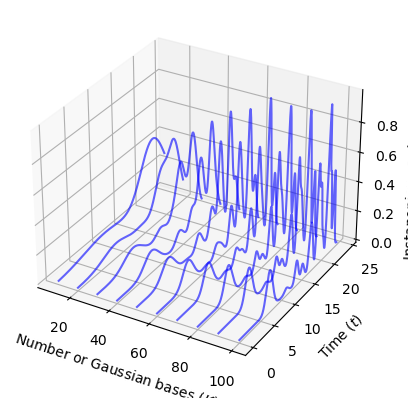

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for K_ in np.arange(10, 110, 10):
    weights_k = pd.read_csv(f'kaalud/{K_}.csv')['a']
    k_ = np.arange(1, K_ + 1)
    locs_k = ((k_ - 1) * tau) / (K_ - 1)
    scales_k = tau / k_
    
    time = np.linspace(0, 24, 500)
    arrival_rate = [rate(t, weights_k, locs=locs_k, scales=scales_k) for t in time]
    
    ax.plot(time, arrival_rate, zs=K_, zdir='x', color='b', alpha=0.6)

ax.set_xlabel('Number or Gaussian bases $(K)$')
ax.set_ylabel('Time $(t)$')
ax.set_zlabel('Instanenious arrival rate $(\\lambda_z)$')

# plt.savefig('joonised/intensiivsused.png', dpi=100)
plt.show()